In [1]:
import os
import pandas as pd
import numpy as np

import zipfile
from urllib import request

def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('저장되었습니다')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [2]:
# 파일 다운받을 때 한번만 실행
download_ml100k()

In [3]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

/var/folders/3c/k281jc6s6yq4s3qndkn6tw880000gn/T/ipykernel_12291/114522661.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


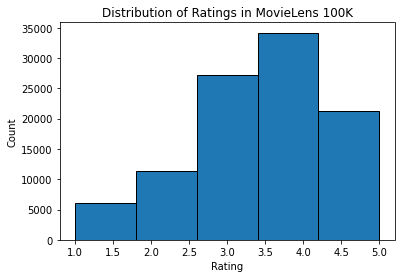

In [4]:
import matplotlib.pyplot as plt

plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()



In [5]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [6]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [63]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ArrayDataset(Dataset):

    def __init__(self, user, item, rating, transform=None):
        self.user = user
        self.item = item
        self.rating = rating
        self.transform = transform

    def __getitem__(self, idx):
        arr = np.column_stack((self.user, self.item, self.rating))
        if self.transform:
            arr = self.transform(arr)
        return arr[idx]
    
    def __len__(self):
        return len(self.user)

In [65]:
def collate_batch(batch):
    batch = np.array(batch)
    return batch[:,0], batch[:,1], batch[:,2]

In [73]:
#@save
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = DataLoader(
        train_set, shuffle=True,
        batch_size=batch_size, collate_fn = collate_batch)
    test_iter = DataLoader(
        test_set, batch_size=batch_size, collate_fn = collate_batch)
    return num_users, num_items, train_iter, test_iter

In [74]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k()

/var/folders/3c/k281jc6s6yq4s3qndkn6tw880000gn/T/ipykernel_12291/98905734.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


In [75]:
next(iter(train_iter))

(array([ 55, 345, 338, 621, 591, 388, 791, 159, 853, 398, 550, 292, 144,
        608, 600, 114, 697, 159, 939,   6, 292, 772, 173, 560, 493, 173,
        325, 377, 656, 915, 457,  62, 629, 941, 795, 331, 803, 629, 193,
        337, 124, 532, 263, 244, 720, 404, 456, 845, 780, 115, 898, 822,
        713, 846, 124,  45,  61, 842, 295, 588, 631, 388,  84, 880, 297,
        377,  84, 275, 797, 782, 605,  27, 889,   0, 886, 391, 925, 534,
        415, 313, 824, 713, 670,   6,  98, 385, 536, 843, 649, 637, 108,
        305,  21, 199, 457,  22, 895, 592, 728, 286,  22, 523,  58,  20,
        455, 565, 560, 681, 804,  75, 731, 560, 467, 499,  13, 434, 240,
        802, 243, 157, 340, 869, 197,  36, 428, 289, 516, 497, 328, 614,
        866,  66,  12, 592,   6, 550, 422, 665,  94, 149, 212, 295, 255,
         40, 108, 313,  61,  93, 601, 555, 627, 310, 832, 377, 319, 762,
        441,  61,  93, 607, 923,  43, 721, 665,  21, 542, 597, 653, 524,
        467, 602,   6,  15, 767, 283, 379, 300, 222